## 1. Data source: PPG-DaLiA (Zenodo benchmark: PPGDalia)

**Dataset:** *PPGDalia* (time-series regression benchmark derived from the public **PPG-DaLiA** dataset)

- **Zenodo record (download + description):**  
    - https://doi.org/10.5281/zenodo.3902728  
- **Original dataset page (background / context):**  
    - https://archive.ics.uci.edu/ml/datasets/PPG-DaLiA  
- **Local path (expected):** download + unzip into `./data/PPGDalia/`    
- **License:** Creative Commons Attribution 4.0 International (**CC BY 4.0**)

PPG-DaLiA is a public wearable physiology dataset for **wrist PPG-based heart rate estimation under motion**. It includes recordings from **15 subjects** performing a range of real-life activities, with **ECG-derived heart rate** as ground truth. The Zenodo **PPGDalia** variant used here is a **benchmark-ready export**: it is **pre-segmented into windows** and distributed in a standardized time-series regression format (the `.ts` format). Signals in this benchmark version are provided as ML-ready time series (segmented and typically normalized/standardized for benchmarking), and the `.ts` files do not preserve physical sensor units.

**File format (Zenodo benchmark):** two `.ts` files with a predefined split:  
- `PPGDalia_TRAIN.ts`  
- `PPGDalia_TEST.ts`  

Each sample is **one window** (one multivariate time series) with:  
- **4 dimensions**: `dim_0`, `dim_1`, `dim_2`, `dim_3`  
- **1 target label** per window: **heart rate (bpm)**  

**Channel meaning (from dataset description):**  
- `dim_0`: wrist **PPG**  
- `dim_1–dim_3`: wrist **accelerometer (x, y, z)**  

*(The `.ts` header does not explicitly name channels; we treat the 4 dimensions as 1×PPG + 3×ACC as described.)*

**What we use in this notebook:** the provided **TRAIN/TEST split**, using **wrist PPG + wrist ACC** as inputs and **HR (bpm)** as the regression target. We keep preprocessing minimal and focus on **motion-aware / reliability features** and **robust evaluation**.


## 2. Load data (TRAIN/TEST) + quick inspection

We load the pre-defined `PPGDalia_TRAIN.ts` / `PPGDalia_TEST.ts` files from `./data/PPGDalia/`, convert the HR labels to numeric, and run a few quick sanity checks (shapes, value ranges, and a single-sample peek).


In [1]:
from pathlib import Path
import numpy as np
from sktime.datasets import load_from_tsfile

DATA_DIR = Path("../data/PPGDalia")
train_path = DATA_DIR / "PPGDalia_TRAIN.ts"
test_path  = DATA_DIR / "PPGDalia_TEST.ts"

assert train_path.exists(), f"Missing: {train_path}"
assert test_path.exists(), f"Missing: {test_path}"

# Load (default return type is a DataFrame of nested series)
X_train, y_train = load_from_tsfile(train_path)
X_test,  y_test  = load_from_tsfile(test_path)

# Labels sometimes load as strings; convert to float
y_train = np.asarray(y_train, dtype=float)
y_test  = np.asarray(y_test, dtype=float)

print("Loaded:")
print(f"  X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"  X_test : {X_test.shape}  | y_test : {y_test.shape}")

# Basic sanity checks
n_channels = X_train.shape[1]
print("\nChannels (dims):", n_channels)
print("HR (bpm) train: min/median/max =",
      f"{y_train.min():.1f} / {np.median(y_train):.1f} / {y_train.max():.1f}")
print("HR (bpm) test : min/median/max =",
      f"{y_test.min():.1f} / {np.median(y_test):.1f} / {y_test.max():.1f}")

# Peek at a single sample: length per channel
i = 0
lengths = [len(X_train.iloc[i, d]) for d in range(n_channels)]
print(f"\nExample window index {i} (train): lengths per dim =", lengths)

# Show a tiny preview (first few y values)
print("\nFirst 5 HR labels (train):", y_train[:5])


Loaded:
  X_train: (43215, 4) | y_train: (43215,)
  X_test : (21482, 4)  | y_test : (21482,)

Channels (dims): 4
HR (bpm) train: min/median/max = 41.9 / 85.8 / 187.0
HR (bpm) test : min/median/max = 41.7 / 83.8 / 171.1

Example window index 0 (train): lengths per dim = [512, 256, 256, 256]

First 5 HR labels (train): [49.61136908 50.32399248 52.70833578 55.64079409 57.65840574]


## 3. Signal sanity-check and channel naming

We visually inspect a couple of example windows to confirm which channel corresponds to PPG versus motion.

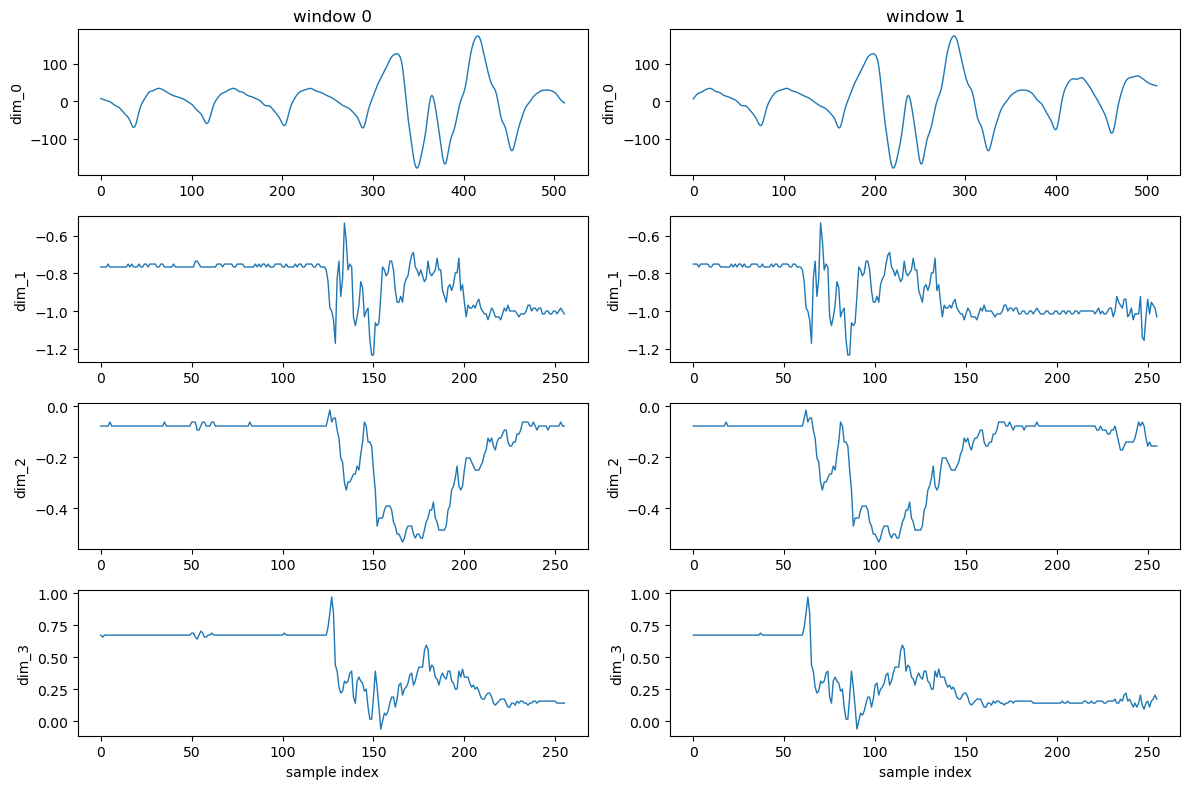

In [2]:
import matplotlib.pyplot as plt

# example windows
idxs = [0, 1]
fig, axes = plt.subplots(4, 2, figsize=(12, 8), sharex=False, sharey=False)

for col, i in enumerate(idxs):
    for d in range(4):
        x = X_train.iloc[i, d].to_numpy(dtype=float)
        axes[d, col].plot(x, lw=1)
        axes[d, col].set_ylabel(f"dim_{d}")
        if d == 0:
            axes[d, col].set_title(f"window {i}")

axes[-1, 0].set_xlabel("sample index")
axes[-1, 1].set_xlabel("sample index")
plt.tight_layout()
plt.show()

- The quasi-periodic waveform of dim_0 confirms it to be the `ppg` channel.  
- The shorter length, step changes and bursts observed at dim_1 to dim_3 confirms them to be our `acc_x`, `acc_y`, `acc_z` channels. 

In [3]:
# Renaming
CHANNELS = ["ppg", "acc_x", "acc_y", "acc_z"]

X_train = X_train.copy()
X_test = X_test.copy()

X_train.columns = CHANNELS
X_test.columns = CHANNELS

print("Info X_train:\n")
print(X_train.info())
print("\nInfo X_test:\n")
print(X_test.info())

Info X_train:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43215 entries, 0 to 43214
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ppg     43215 non-null  object
 1   acc_x   43215 non-null  object
 2   acc_y   43215 non-null  object
 3   acc_z   43215 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB
None

Info X_test:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21482 entries, 0 to 21481
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ppg     21482 non-null  object
 1   acc_x   21482 non-null  object
 2   acc_y   21482 non-null  object
 3   acc_z   21482 non-null  object
dtypes: object(4)
memory usage: 671.4+ KB
None
